In [1]:
pip install opencv-python numpy scipy matplotlib

In [2]:
import cv2
import numpy as np
from scipy.linalg import svd
from matplotlib import pyplot as plt
import os
from google.colab import files

Saving IM1.jpg to IM1 (1).jpg
Saving IM2.jpg to IM2 (1).jpg
Saving IM3.jpg to IM3 (1).jpg
Processing: IM1 (1).jpg


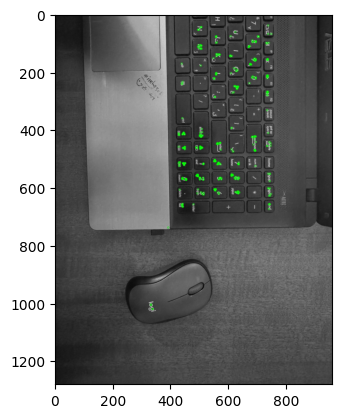

Processing: IM2 (1).jpg


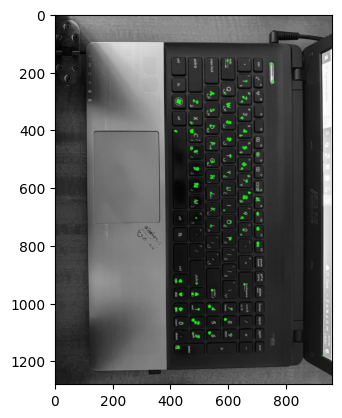

Processing: IM3 (1).jpg


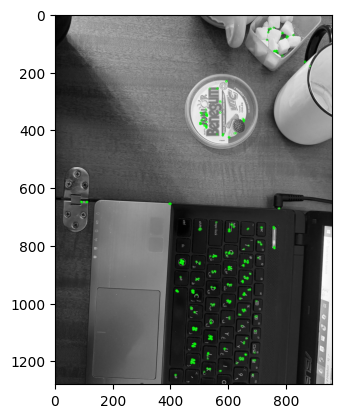

In [30]:
# Use this to upload all images
uploaded = files.upload()

image_paths = list(uploaded.keys())

# Initialize a counter for image numbering
image_counter = 1

# Now you can process the images:
for image_path in image_paths:
    try:
        img = cv2.imdecode(np.frombuffer(uploaded[image_path], np.uint8), cv2.IMREAD_COLOR)
        # Now you have the image loaded as 'img'. You can do further operations:
        print(f'Processing: {image_path}')

        # Convert the image to grayscale
        gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Initiate ORB detector
        orb = cv2.ORB_create()

        # find the keypoints and descriptors with ORB
        kp, des = orb.detectAndCompute(gray_image,None)

        # Draw keypoints on the image
        img2 = cv2.drawKeypoints(gray_image,kp,None,color=(0,255,0), flags=0)

        # Save the image with keypoints using the counter
        cv2.imwrite(f'IM_Key{image_counter}.jpg', img2)

        # Display the image with keypoints
        plt.imshow(img2), plt.show()

        # Increment the counter for the next image
        image_counter += 1

    except Exception as e:
        print(f'Error processing {image_path}: {e}')

Saving IM1.jpg to IM1 (15).jpg
Saving IM2.jpg to IM2 (15).jpg
Saving IM3.jpg to IM3 (15).jpg
Processing: IM1 (15).jpg


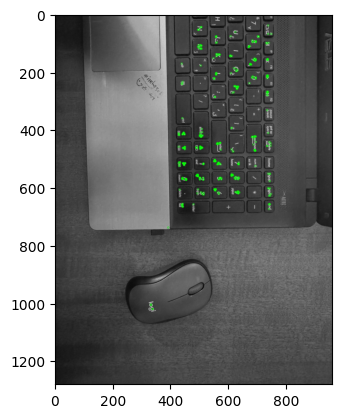

Processing: IM2 (15).jpg


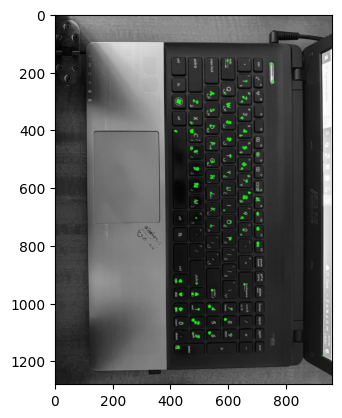

Processing: IM3 (15).jpg


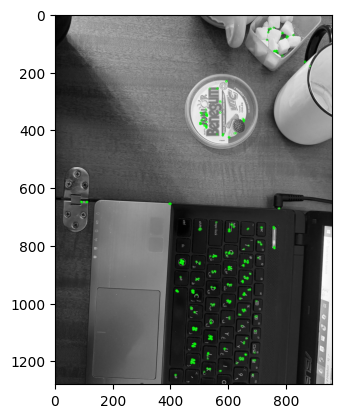

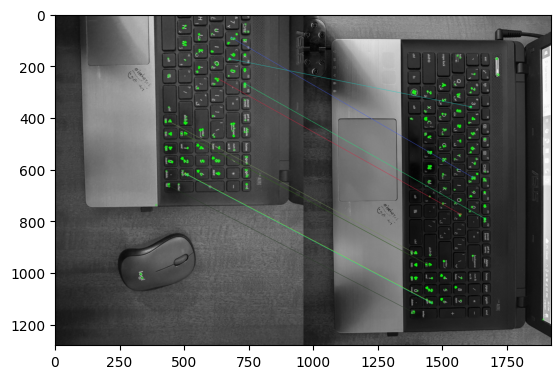

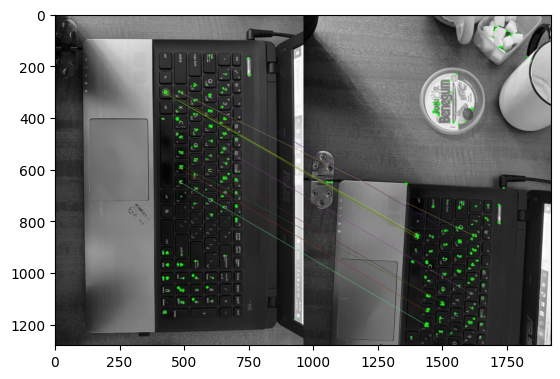

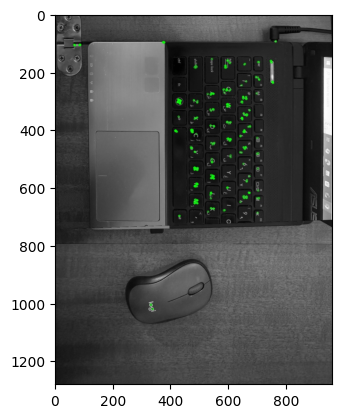

In [62]:

def process_images(uploaded):
    """Processes uploaded images to find and store keypoints and descriptors."""
    image_keypoints = {}
    image_counter = 1
    for image_path in uploaded:
        try:
            img = cv2.imdecode(np.frombuffer(uploaded[image_path], np.uint8), cv2.IMREAD_COLOR)
            print(f'Processing: {image_path}')
            gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            orb = cv2.ORB_create()
            kp, des = orb.detectAndCompute(gray_image, None)
            image_keypoints[f'IM_Key{image_counter}'] = (kp, des)
            img2 = cv2.drawKeypoints(gray_image, kp, None, color=(0, 255, 0), flags=0)
            cv2.imwrite(f'IM_Key{image_counter}.jpg', img2)
            plt.imshow(img2), plt.show()
            image_counter += 1
        except Exception as e:
            print(f'Error processing {image_path}: {e}')
    return image_keypoints

def feature_matching(image_keypoints):
    """Performs feature matching between consecutive images using BFMatcher."""
    for i in range(1, len(image_keypoints)):
        img1_keypoints, img1_descriptors = image_keypoints[f'IM_Key{i}']
        img2_keypoints, img2_descriptors = image_keypoints[f'IM_Key{i+1}']
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        matches = bf.match(img1_descriptors, img2_descriptors)
        matches = sorted(matches, key=lambda x: x.distance)
        img_matches = cv2.drawMatches(
            cv2.imread(f'IM_Key{i}.jpg'), img1_keypoints,
            cv2.imread(f'IM_Key{i+1}.jpg'), img2_keypoints,
            matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
        )
        plt.imshow(img_matches), plt.show()

def feature_matching_ransac(image_keypoints):
    """Performs feature matching and RANSAC to find homography matrices."""
    homography_matrices = []
    for i in range(1, len(image_keypoints)):
        img1_keypoints, img1_descriptors = image_keypoints[f'IM_Key{i}']
        img2_keypoints, img2_descriptors = image_keypoints[f'IM_Key{i+1}']
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        matches = bf.match(img1_descriptors, img2_descriptors)
        matches = sorted(matches, key=lambda x: x.distance)
        src_pts = np.float32([img1_keypoints[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([img2_keypoints[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        homography_matrices.append(M)
    return homography_matrices

def synchronize_projective_transformations_svd(homographies):
    """Synchronizes homographies using SVD and threading."""
    num_images = len(homographies)
    synchronized_homographies = [np.eye(3) for _ in range(num_images)]
    if num_images > 0:
        threads = []
        results = [None] * num_images
        def process_homography(i):
            U, S, V = svd(homographies[i])
            synchronized_homographies[i] = U @ np.diag(S) @ V
            results[i] = synchronized_homographies[i]
        for i in range(num_images):
            thread = threading.Thread(target=process_homography, args=(i,))
            threads.append(thread)
            thread.start()
        for thread in threads:
            thread.join()
        synchronized_homographies = results
    return synchronized_homographies

def bundle_adjustment(homographies, points2D):
    """Refines homographies using bundle adjustment (placeholder)."""
    # Placeholder for a robust bundle adjustment implementation
    refined_homographies = homographies
    return refined_homographies

def warp_and_stitch(refined_homographies):
    """Warps and stitches images using refined homographies."""
    if len(refined_homographies) > 0:
        ref_img = cv2.imread(f'IM_Key{1}.jpg')
        h, w = ref_img.shape[:2]
        mosaic_width = w
        mosaic_height = h
        mosaic = np.zeros((mosaic_height, mosaic_width, 3), dtype=np.uint8)
        mosaic[:mosaic_height, :mosaic_width] = ref_img

        for i in range(len(refined_homographies)):
            img_to_warp = cv2.imread(f'IM_Key{i+2}.jpg')
            if img_to_warp is not None:
                warped_image = cv2.warpPerspective(img_to_warp, np.linalg.inv(refined_homographies[i]), (w, h))
                # Simple overlay blending (consider more advanced techniques)
                for y in range(mosaic_height):
                    for x in range(w):
                        if np.any(warped_image[y, x] != [0, 0, 0]):
                            mosaic[y, x] = warped_image[y, x]
                mosaic_width = max(mosaic_width, warped_image.shape[1])

        plt.imshow(cv2.cvtColor(mosaic, cv2.COLOR_BGR2RGB)), plt.show()
        cv2.imwrite('mosaic.jpg', mosaic)

# Main execution flow
uploaded = files.upload()
image_keypoints = process_images(uploaded)
feature_matching(image_keypoints)
homography_matrices = feature_matching_ransac(image_keypoints)
synchronized_homographies = synchronize_projective_transformations_svd(homography_matrices)
refined_homographies = bundle_adjustment(synchronized_homographies, points2D=[])  # Placeholder points2D
warp_and_stitch(refined_homographies)